# Experiment 2: Comparison across values of $\alpha$ in dimension 2 with GB copies

In this notebook, we perform computations corresponding to Experiment 2, described in the thesis report. Specifically, we train Gradient Boosting copies (GB) for values of $\alpha \in \{0, 0.25, 0.5, 0.75, 1, 1.25\}$ in the two-dimensional datasets, for each of the 3 different black box models considered in the experiment, that later we compare to the corresponding GB hard copies. All copies are trained on the same 1,000,000 synthetic samples generated with Algorithm 2. Results are stored in the corresponding results folder present in the repository.

As a remark, this particular notebook corresponds to the execution with seed 45. Nevertheless, the computations have been repeated for five different seeds (41, 42, 43, 44, and 45), aiming to increase the reliability and significance of the obtained results.

In [1]:
# All necessary imports
import numpy as np
import os
import types
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from time import perf_counter
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.colors as mcolors
import random
import pickle
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras import Model as KerasModel
import gc



original_cwd = os.getcwd()
os.chdir('../utils')
from utils import *
os.chdir(original_cwd)

In [2]:
# Set the seed
seed = 45
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

# Create a wrapper for our Neural network black boxes
def bbmodelW(x):
    if isinstance(bbmodel, tf.keras.models.Model):
        return np.where(bbmodel(x) > 0.5, 1, -1).flatten()
    return np.where(bbmodel.predict(x) > 0.5, 1, -1).flatten()

## Overlapping Gaussians dataset

In [3]:
# Import dataset
data_train = np.load("../data/Synth_dataset_1_train.npz")
X_train = data_train["X"]
y_train = data_train["y"]

data_test = np.load("../data/Synth_dataset_1_test.npz")
X_test = data_test["X"]
y_test = data_test["y"]

### Black box 1: Random Forest classifier

In [4]:
# Define, train and evaluate the black box
bbmodel = RandomForestClassifier(max_depth=10, min_samples_leaf=5)
bbmodel.fit(X_train, y_train)
yhat = bbmodel.predict(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == y_test)

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [5]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


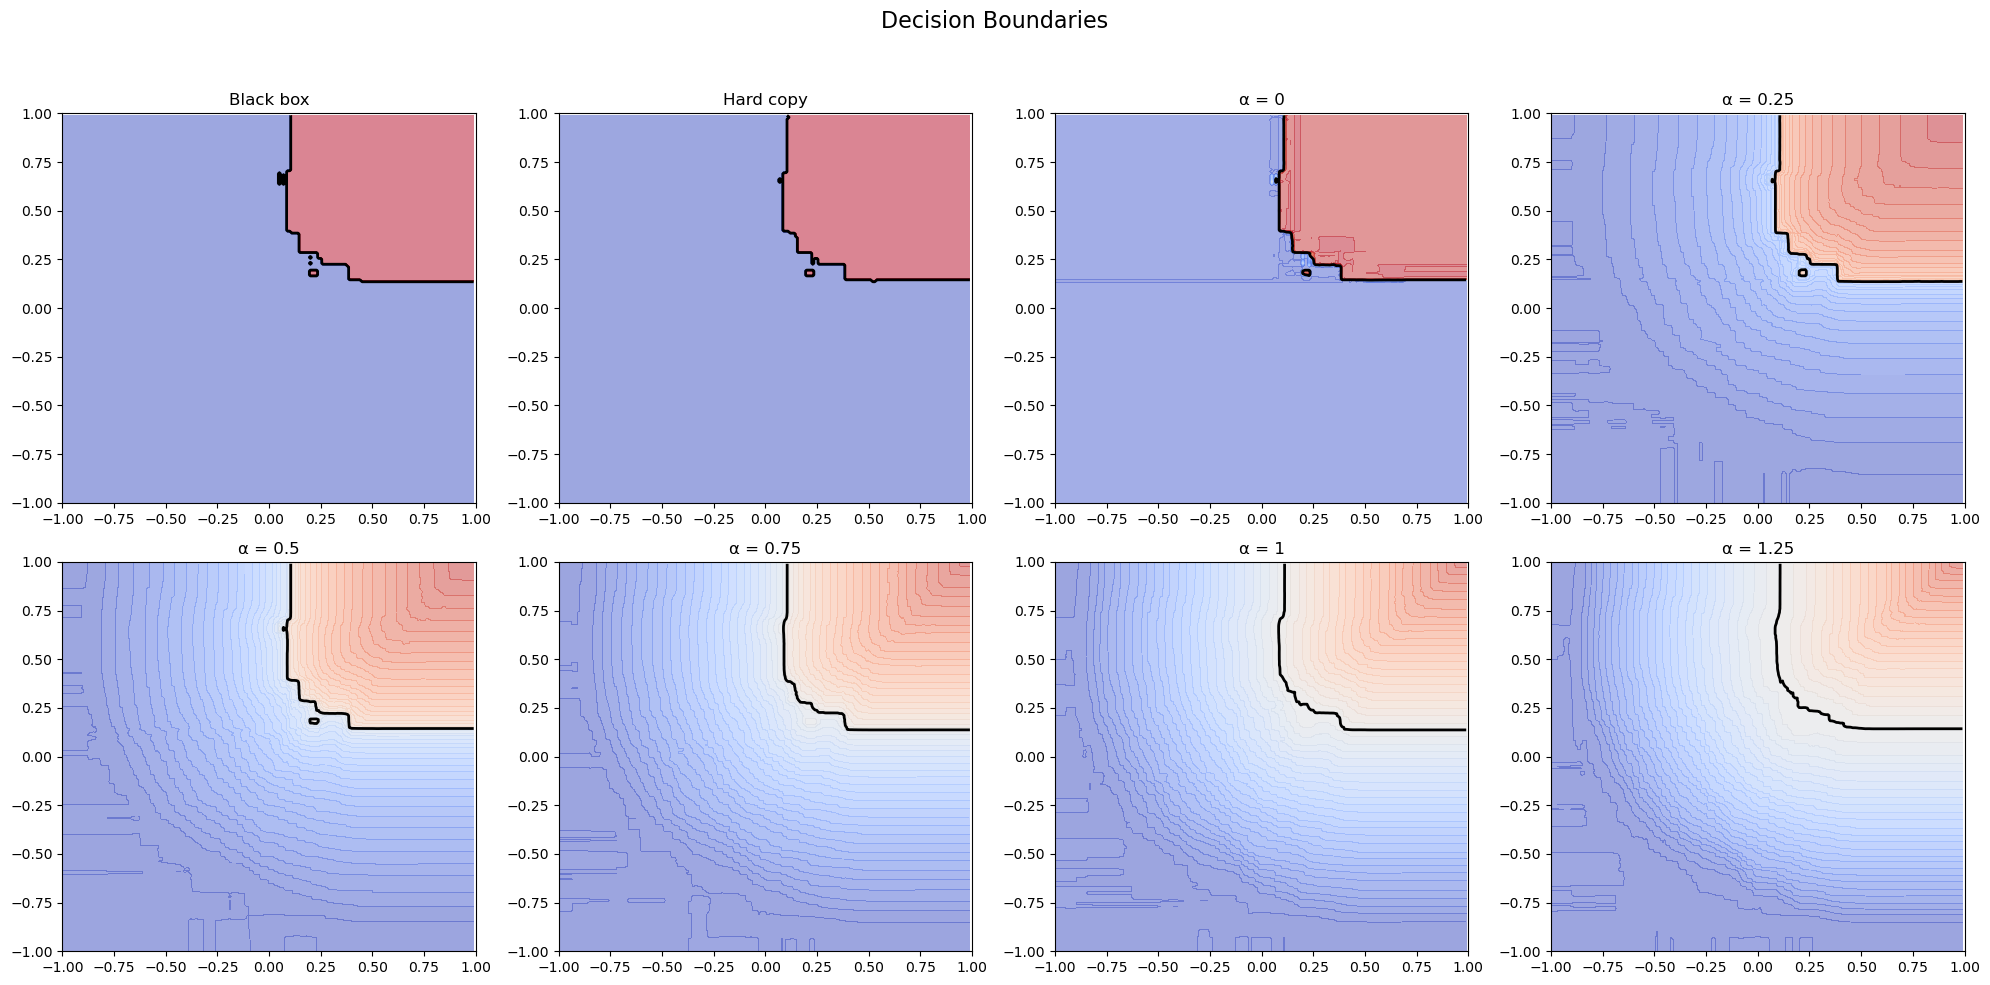

In [6]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [7]:
filename = f"../results/alpha_DS1_1_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

26268

### Black box 2: Gradient Boosting classifier

In [8]:
# Define, train and evaluate the black box
bbmodel = HistGradientBoostingClassifier()
bbmodel.fit(X_train, y_train)
yhat = bbmodel.predict(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == y_test)

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [9]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


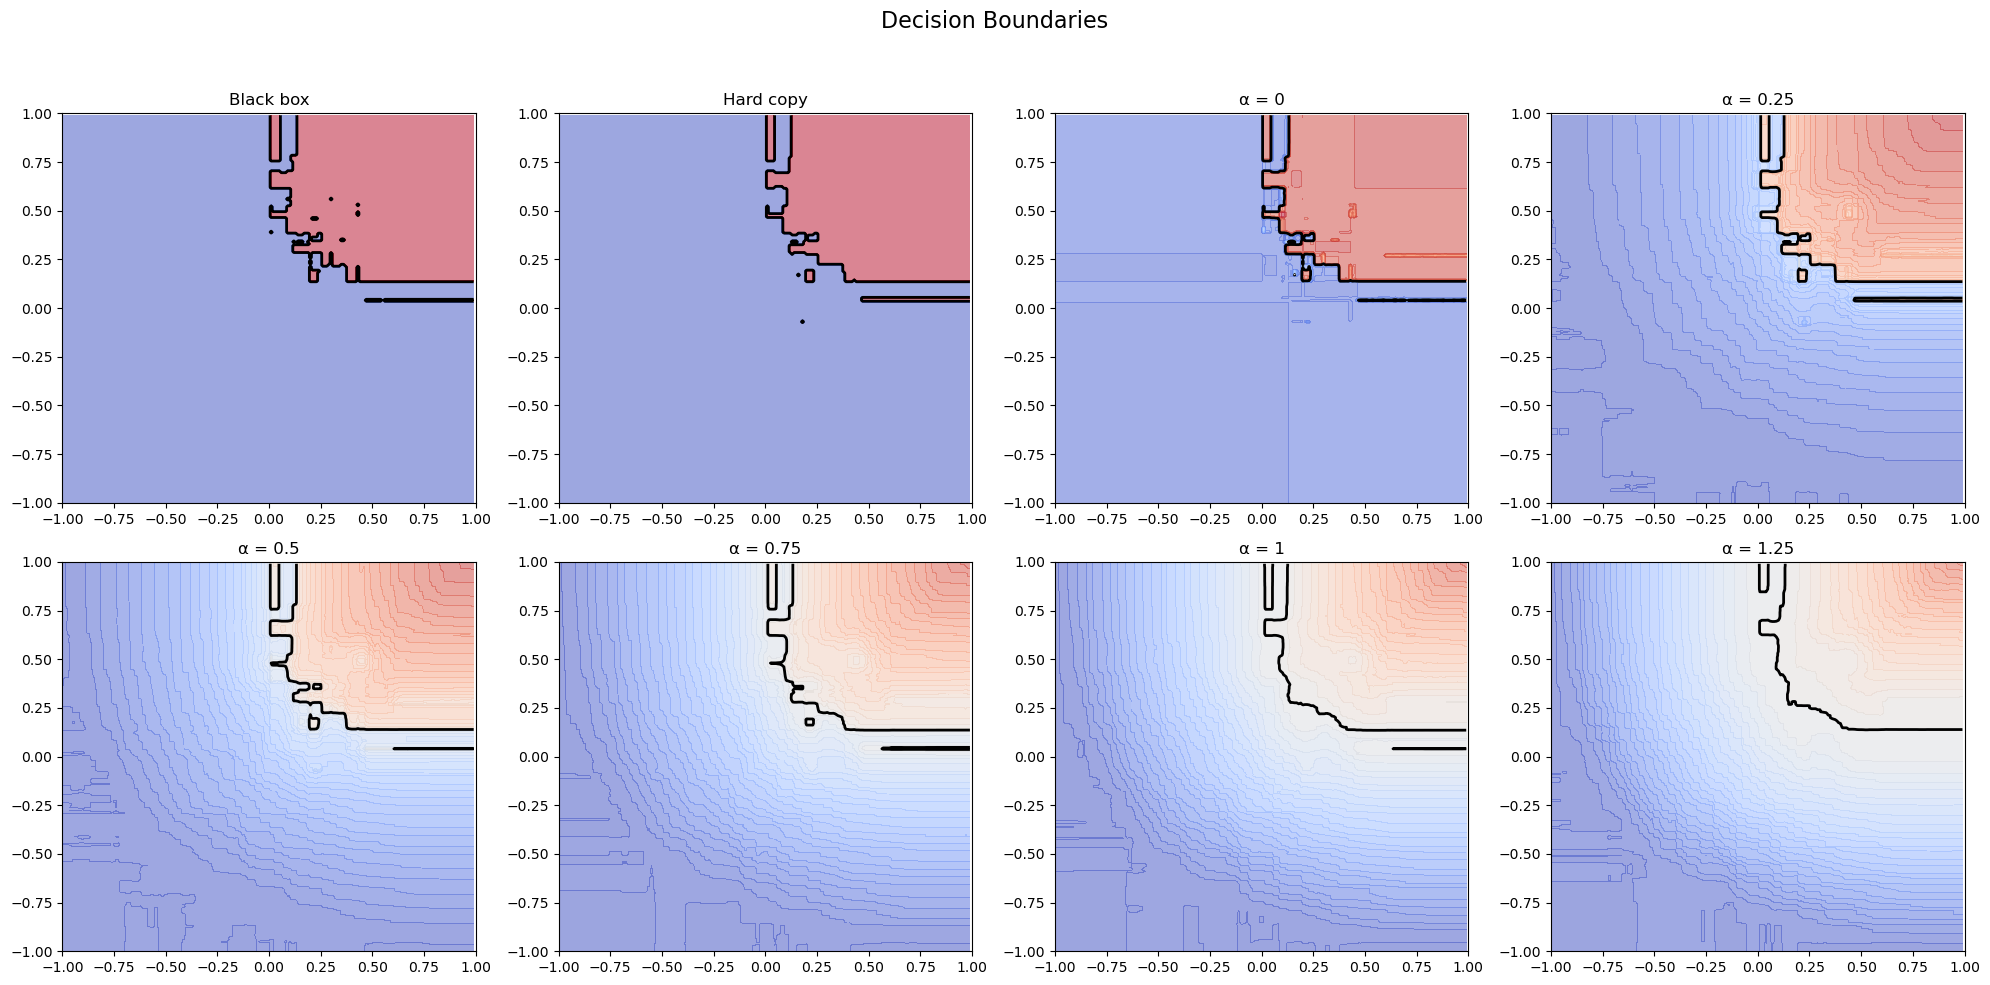

In [10]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [11]:
filename = f"../results/alpha_DS1_2_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

26683

### Black box 3: Neural Network classifier

In [12]:
# Define, train and evaluate the black box
bbmodel = keras.Sequential(
    [
        layers.Dense(128, activation = "relu"),
        layers.Dense(64, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(1, activation = "sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.01)
bbmodel.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy())
bbmodel.fit(X_train, y_train, batch_size=32, epochs=50, verbose = 0)

yhat = bbmodelW(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == (2*y_test-1))

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [13]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


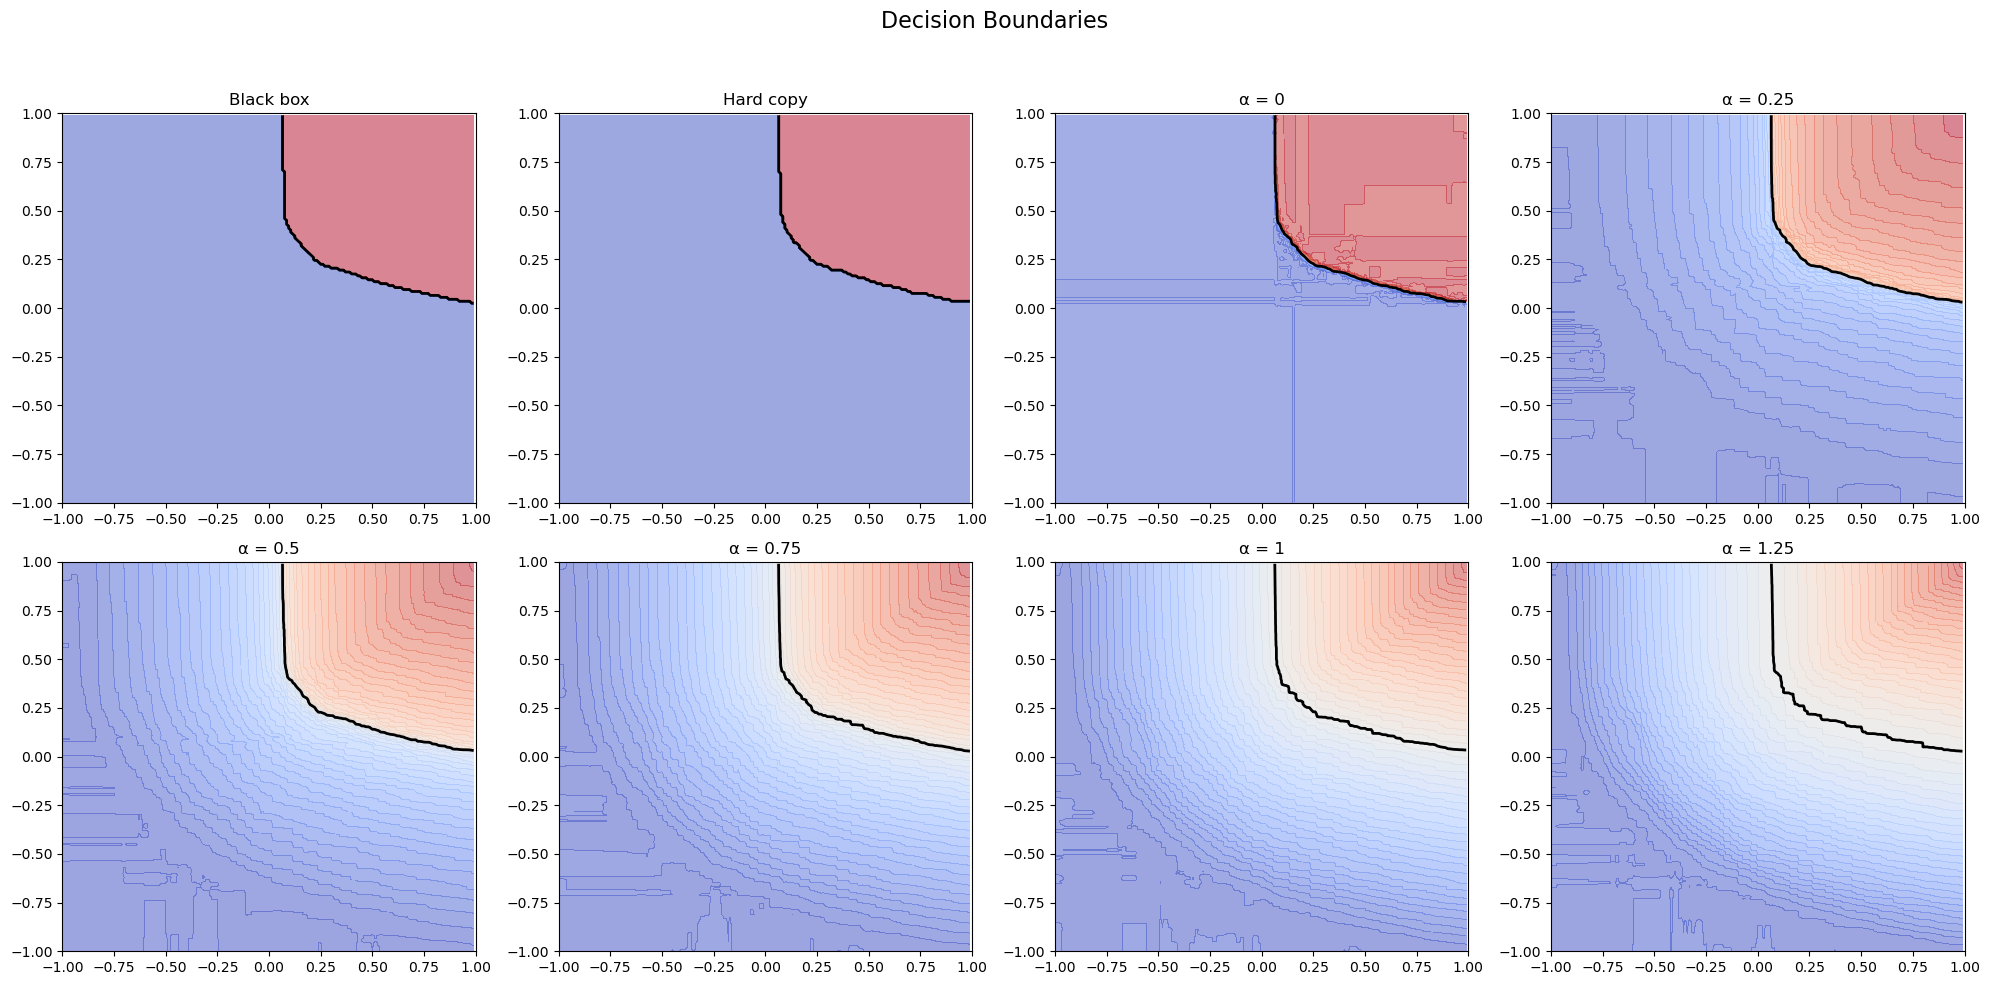

In [14]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [15]:
filename = f"../results/alpha_DS1_3_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

28724

## Two spirals dataset

In [16]:
# Import dataset
data_train = np.load("../data/Synth_dataset_2_train.npz")
X_train = data_train["X"]
y_train = data_train["y"]

data_test = np.load("../data/Synth_dataset_2_test.npz")
X_test = data_test["X"]
y_test = data_test["y"]

### Black box 1: Random Forest classifier

In [17]:
# Define, train and evaluate the black box
bbmodel = RandomForestClassifier(max_depth=10, min_samples_leaf=5)
bbmodel.fit(X_train, y_train)
yhat = bbmodel.predict(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == y_test)

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [18]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


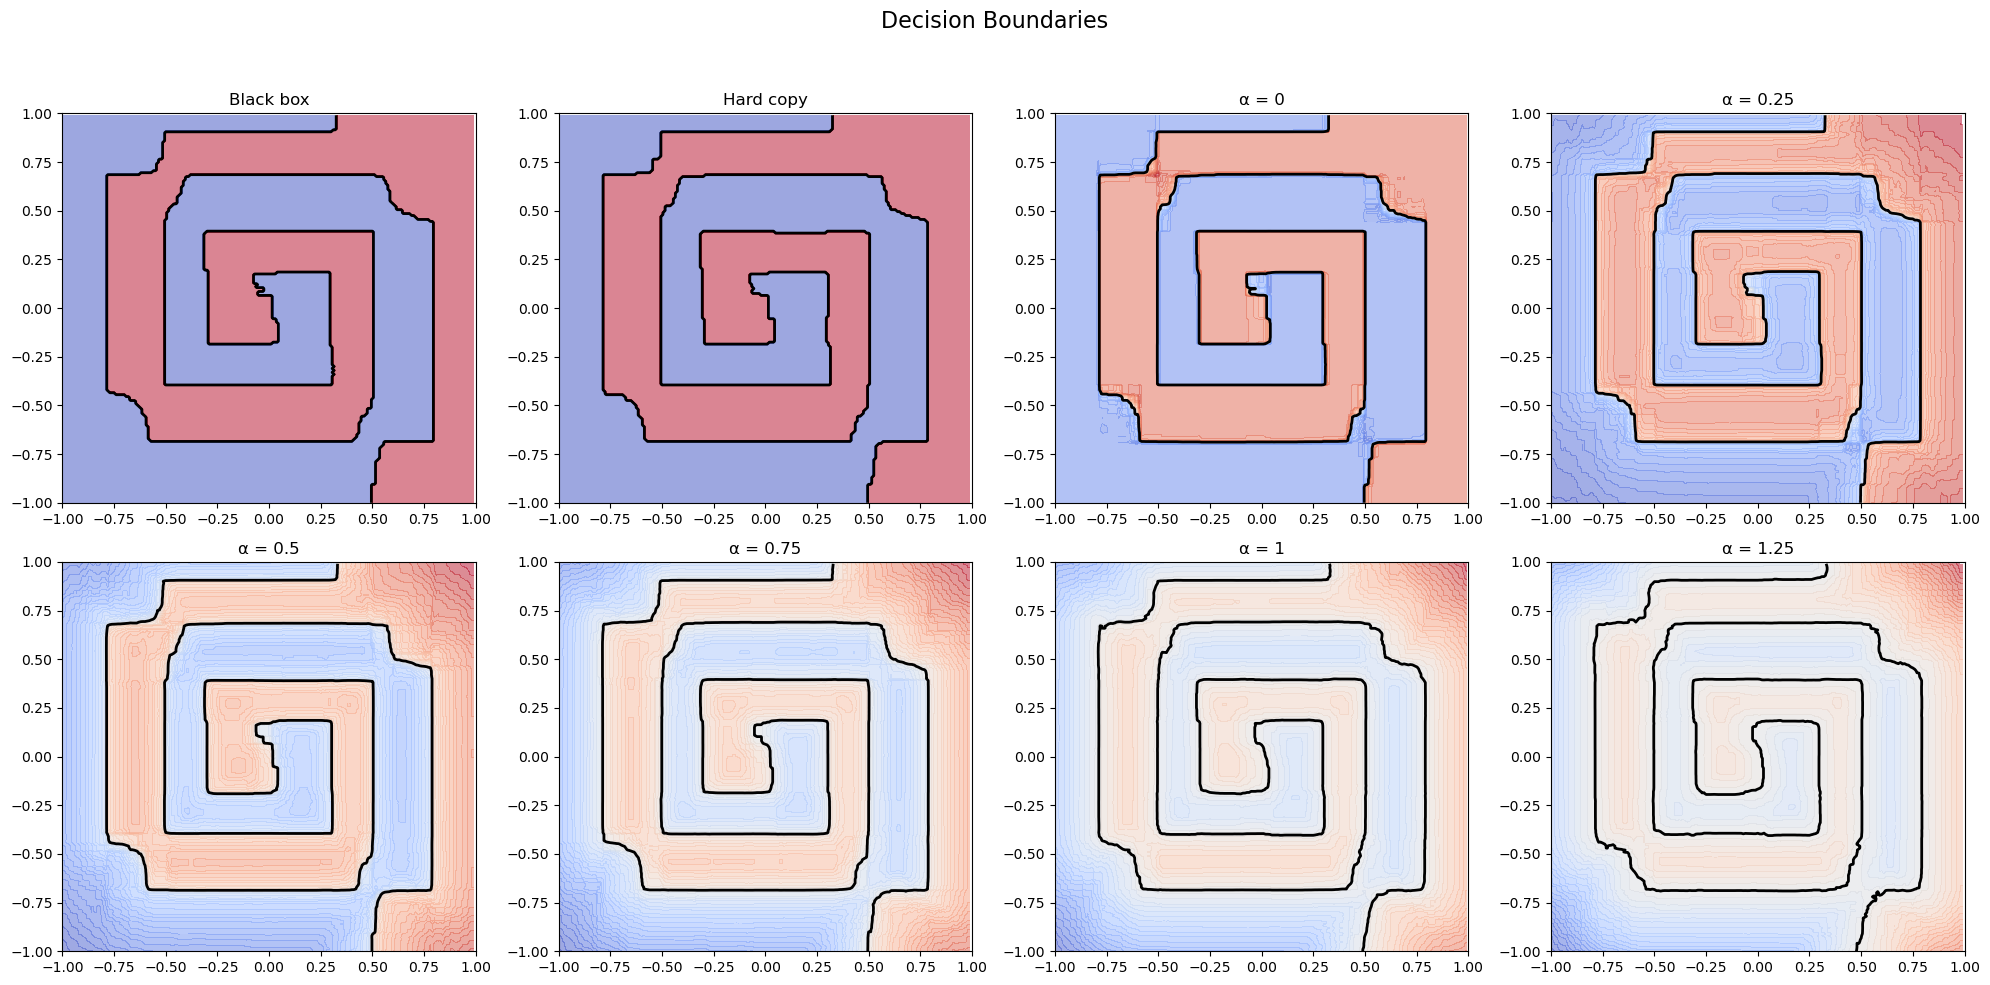

In [19]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [20]:
filename = f"../results/alpha_DS2_1_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

26684

### Black box 2: Gradient Boosting classifier

In [21]:
# Define, train and evaluate the black box
bbmodel = HistGradientBoostingClassifier()
bbmodel.fit(X_train, y_train)
yhat = bbmodel.predict(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == y_test)

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [22]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


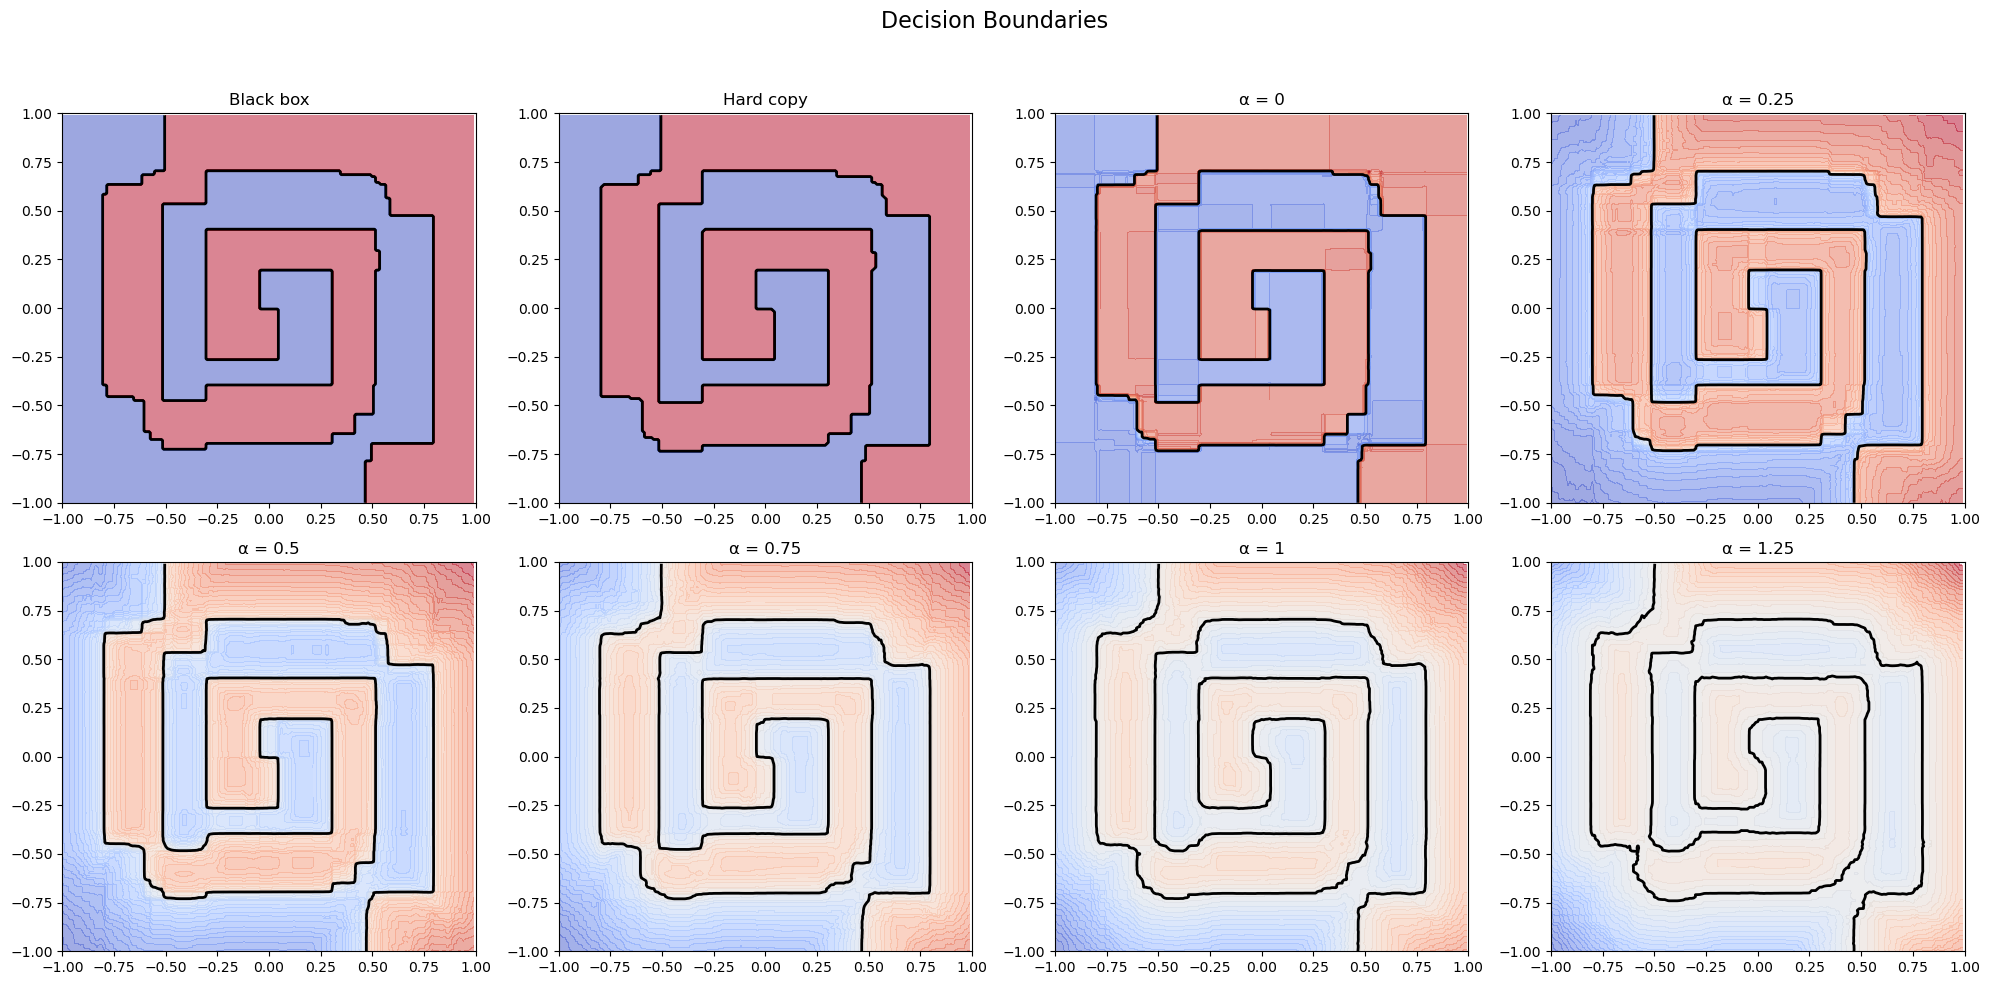

In [23]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [24]:
filename = f"../results/alpha_DS2_2_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

26682

### Black box 3: Neural Network classifier

In [25]:
# Define, train and evaluate the black box
bbmodel = keras.Sequential(
    [
        layers.Dense(128, activation = "relu"),
        layers.Dense(64, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(1, activation = "sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.01)
bbmodel.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy())
bbmodel.fit(X_train, y_train, batch_size=32, epochs=50, verbose = 0)

yhat = bbmodelW(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == (2*y_test-1))

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [26]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


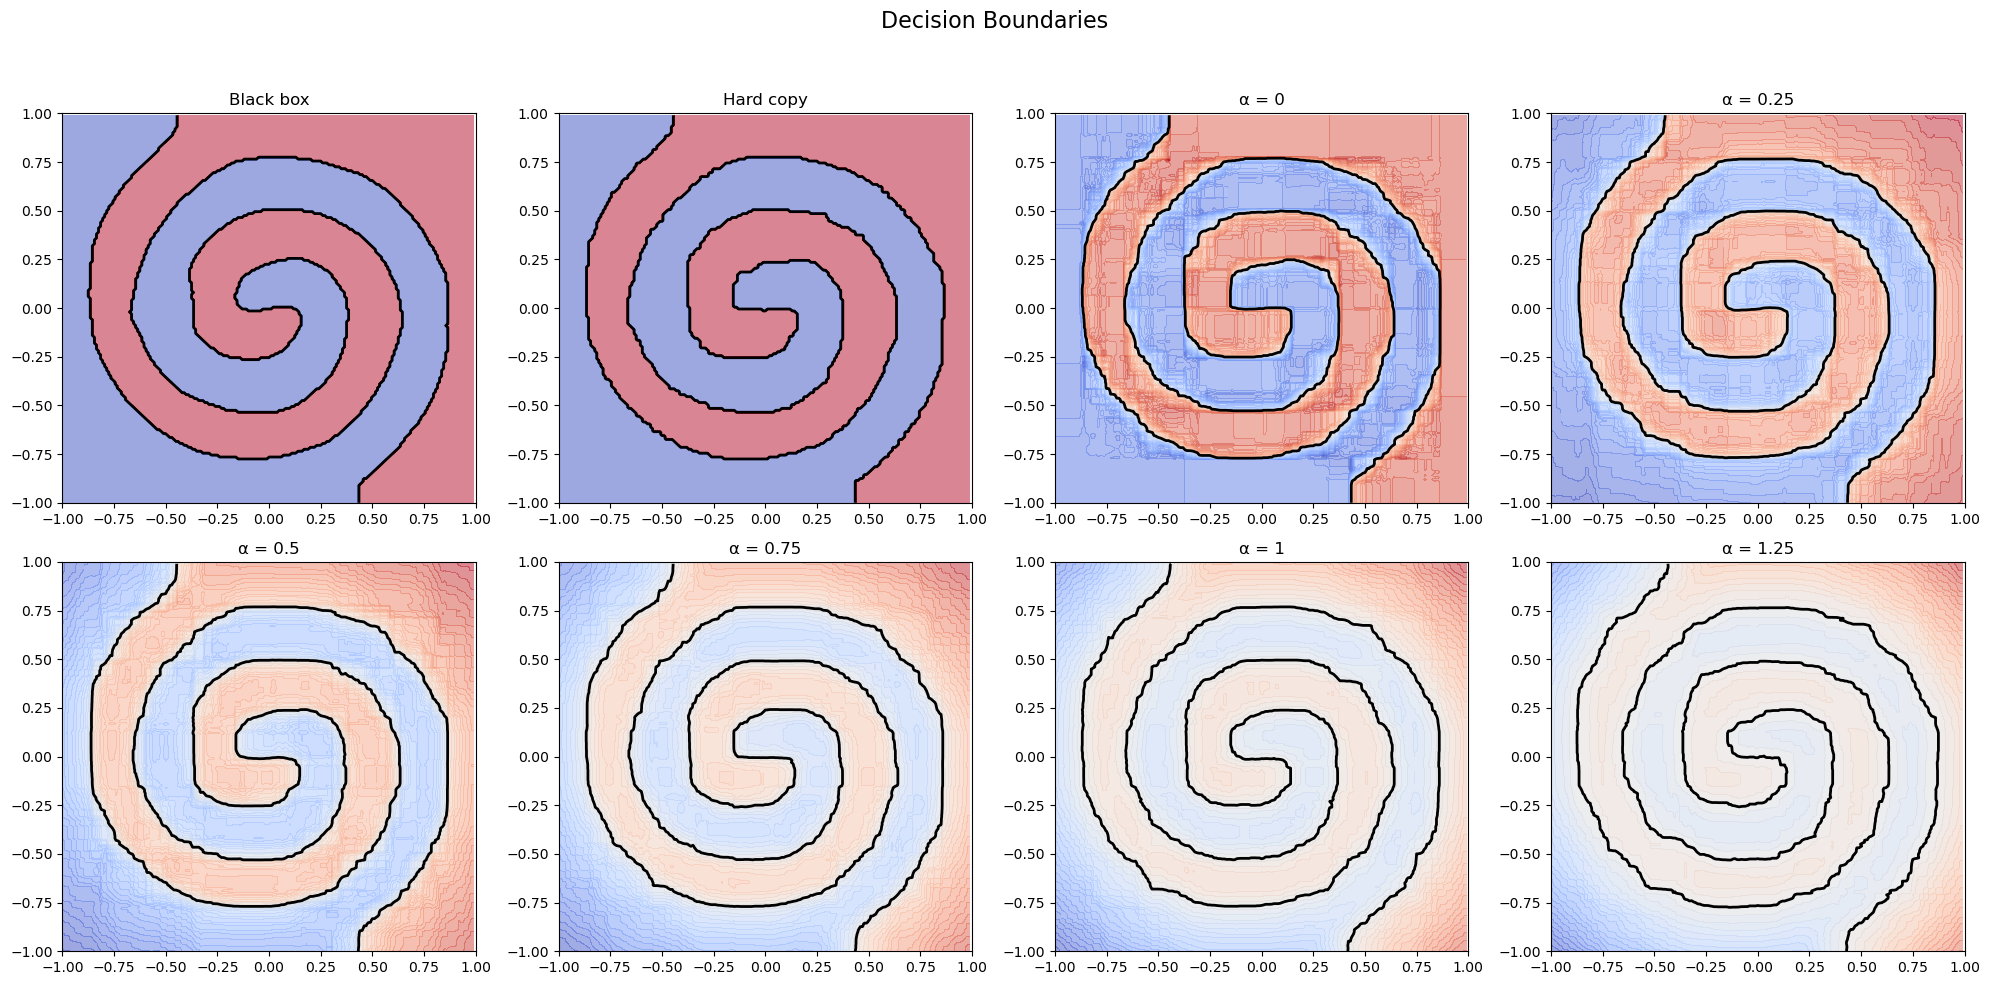

In [27]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [28]:
filename = f"../results/alpha_DS2_3_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

28706

## Space-filling and convoluted dataset

In [29]:
# Import dataset
data_train = np.load("../data/Synth_dataset_3_train.npz")
X_train = data_train["X"]
y_train = data_train["y"]

data_test = np.load("../data/Synth_dataset_3_test.npz")
X_test = data_test["X"]
y_test = data_test["y"]

### Black box 1: Random Forest classifier

In [30]:
# Define, train and evaluate the black box
bbmodel = RandomForestClassifier(max_depth=10, min_samples_leaf=5)
bbmodel.fit(X_train, y_train)
yhat = bbmodel.predict(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == y_test)

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [31]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


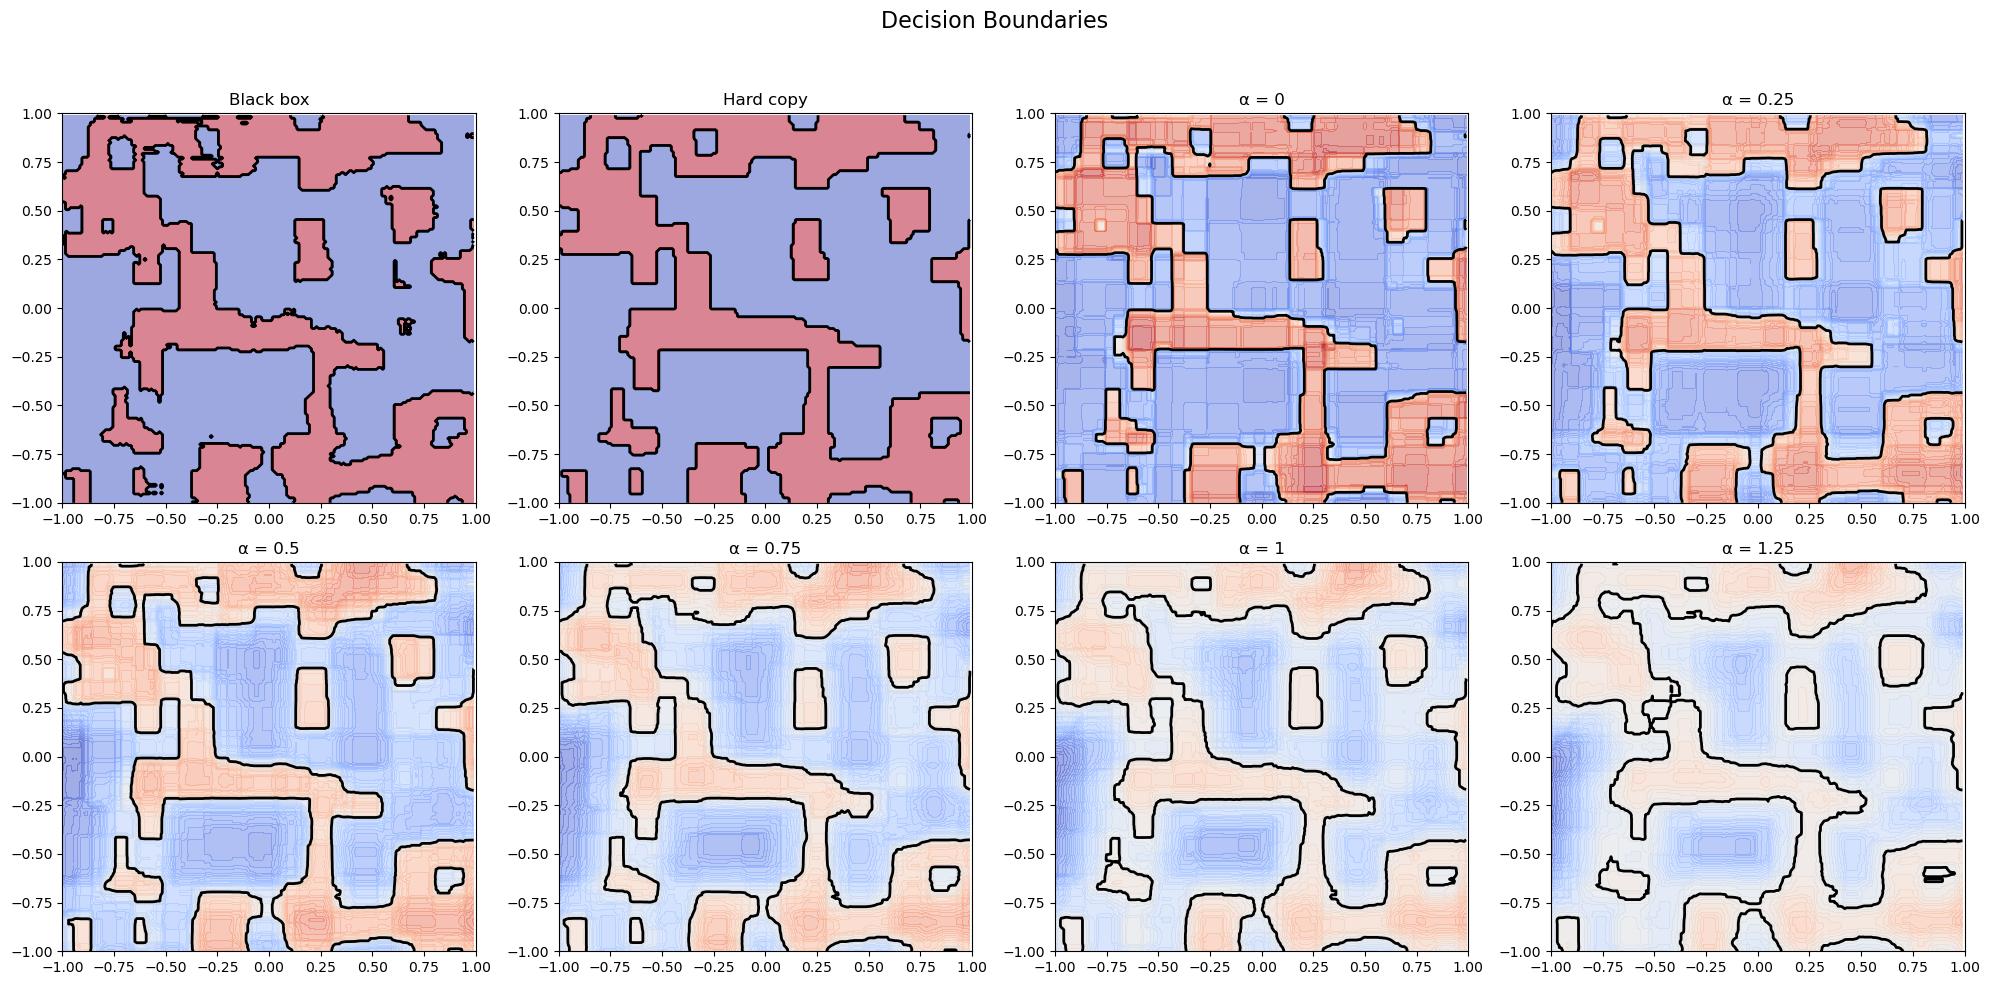

In [32]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [33]:
filename = f"../results/alpha_DS3_1_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

26684

### Black box 2: Gradient Boosting classifier

In [34]:
# Define, train and evaluate the black box
bbmodel = HistGradientBoostingClassifier()
bbmodel.fit(X_train, y_train)
yhat = bbmodel.predict(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == y_test)

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [35]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


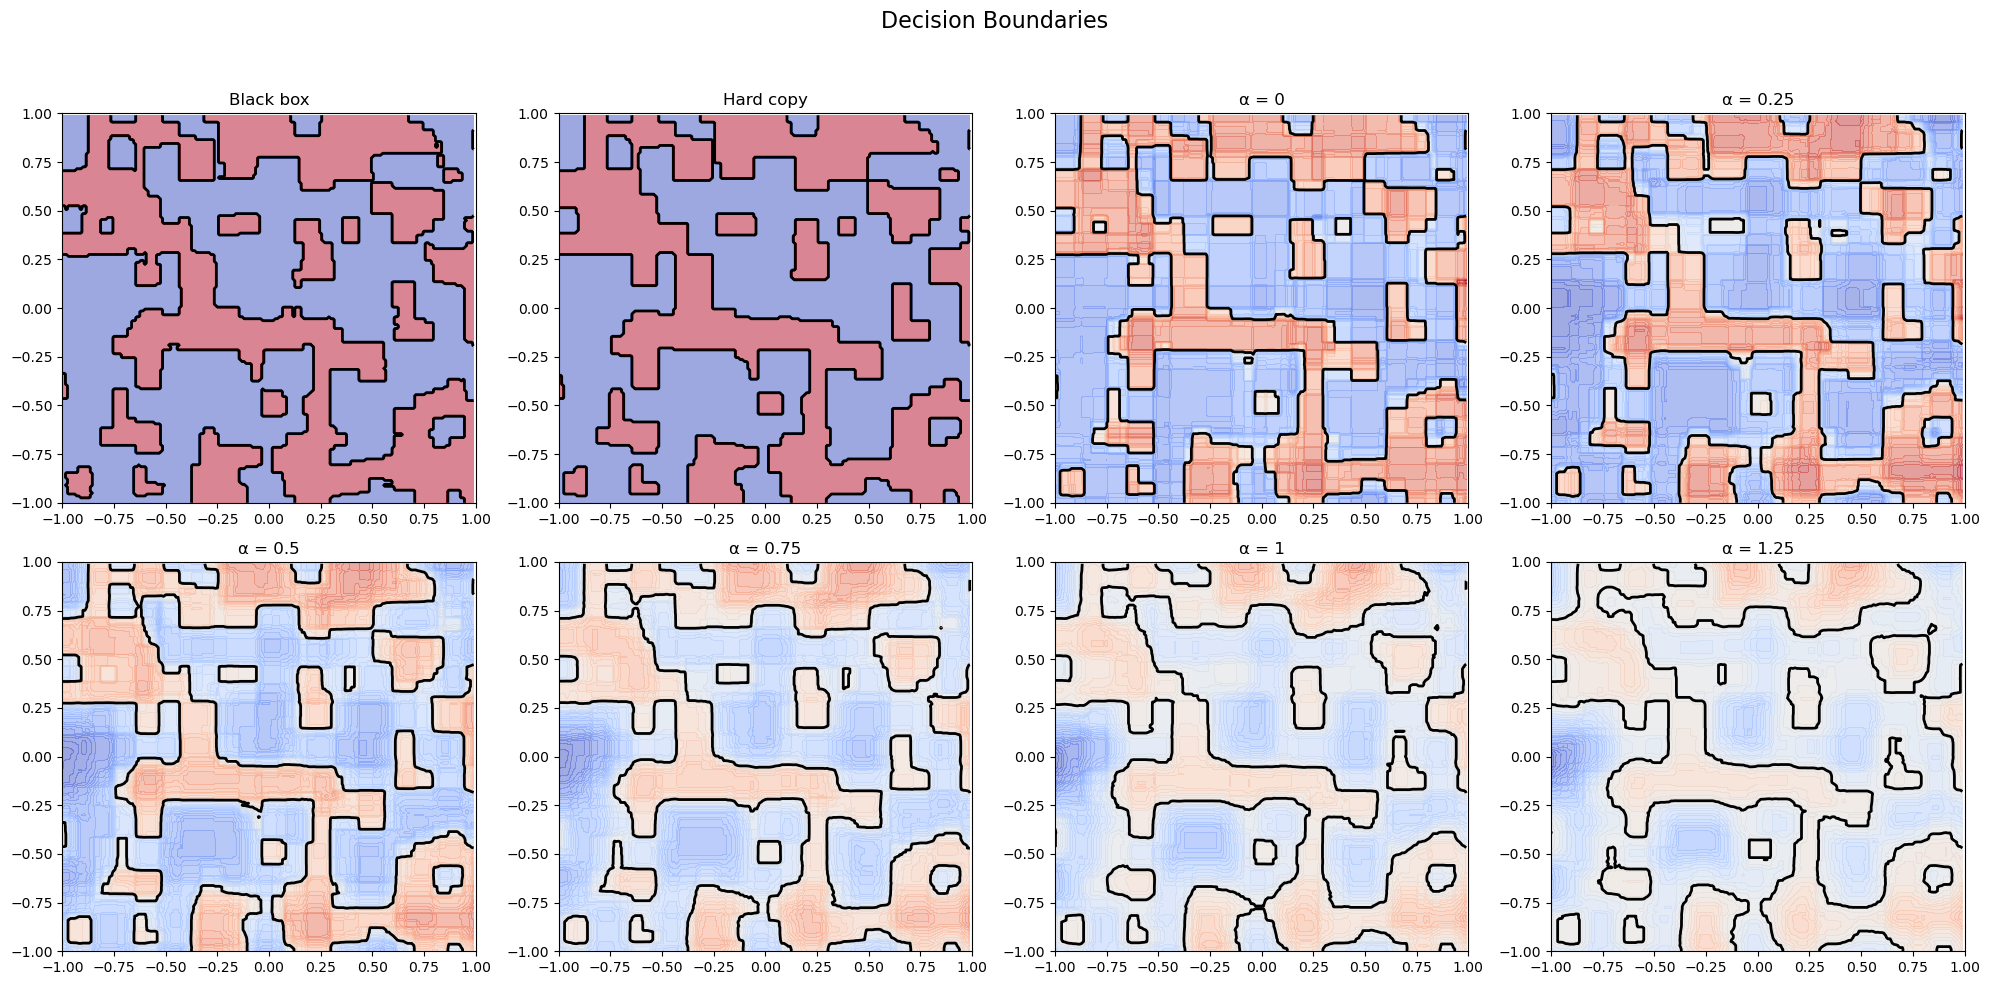

In [36]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [37]:
filename = f"../results/alpha_DS3_2_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

26672

### Black box 3: Neural Network classifier

In [38]:
# Define, train and evaluate the black box
bbmodel = keras.Sequential(
    [
        layers.Dense(128, activation = "relu"),
        layers.Dense(64, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(1, activation = "sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.01)
bbmodel.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy())
bbmodel.fit(X_train, y_train, batch_size=32, epochs=50, verbose=0)

yhat = bbmodelW(X_test)

# Accuracy of the black box
accbb = np.mean(yhat == (2*y_test-1))

# We generate 1,000,000 points uniformly to test the copy. 
data_test_syn = np.random.uniform(-1,1, (1000000, 2))

# We label these points with labels 1 and -1
y_test_syn = bbmodelW(data_test_syn)

In [39]:
pts, data, lab = generate_distances_algo3(2, -1, 1, 40_000, 25, 1_200, 1, 0.1, bbmodelW, 2_000)

We have labelled 10000 points


We have labelled 50000 points


We have labelled 200000 points


We have labelled 400000 points


We have labelled 600000 points


We have labelled 800000 points


We have labelled 1000000 points


Computations done for the hard copy


Computations done for the α = 0 copy


Computations done for the α = 0.25 copy


Computations done for the α = 0.5 copy


Computations done for the α = 0.75 copy


Computations done for the α = 1 copy


Computations done for the α = 1.25 copy


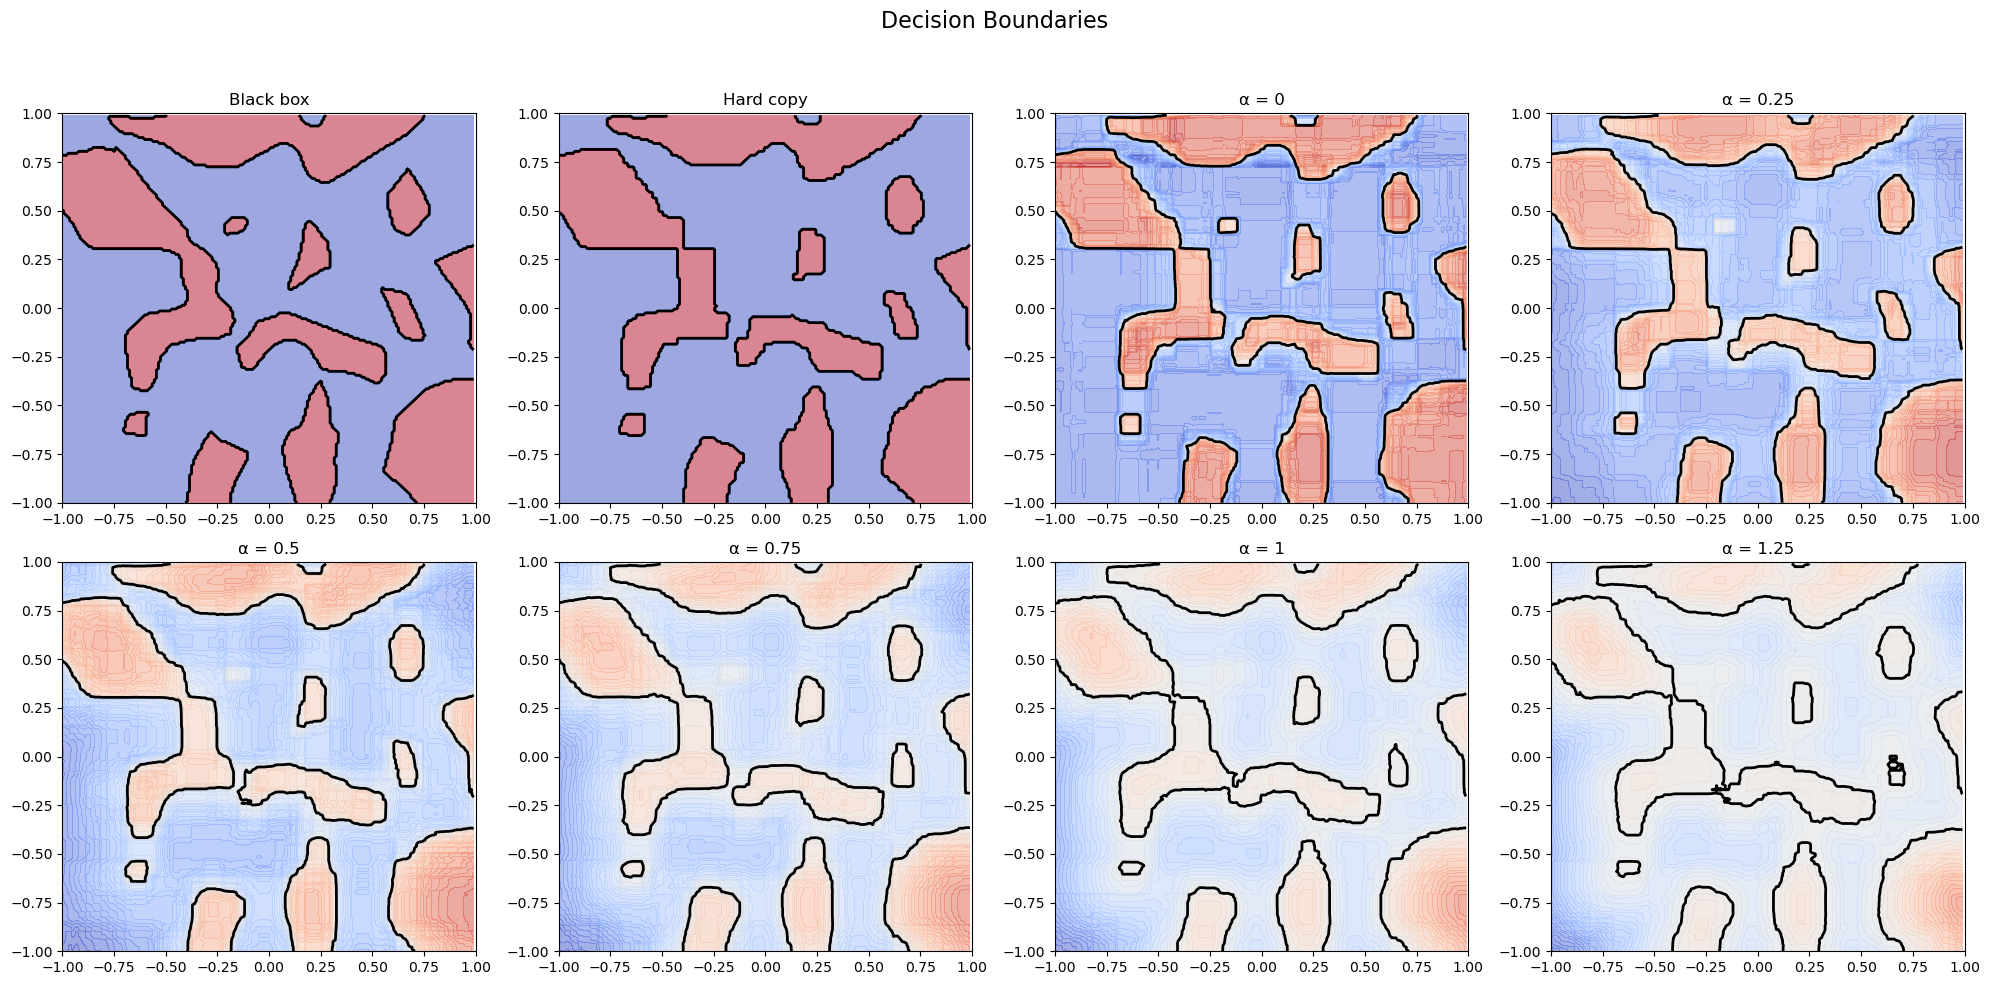

In [40]:
acc, efe_unif = train_copy_GB_conti(data, lab, X_test, y_test, data_test_syn, y_test_syn, bbmodelW)

In [41]:
filename = f"../results/alpha_DS3_3_4_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump({"acc": acc, "efe_unif": efe_unif}, f)

del pts
del efe_unif
del acc
del bbmodel
del accbb
gc.collect()

28712